In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
import contextily as ctx
from config import create_connection_obj

pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [2]:
conn = create_connection_obj()

rawdata = pd.read_sql(sql="SELECT * FROM raw_redfin_data;", con=conn)

In [3]:
def process_raw_data(df):
    """Filter on relevant observations, convert to GeoDataFrame, and drop uncessary columns

    Args:
        df (pd.DataFrame): Raw Redfin data queries from db
    Output:
        df (gpd.GeoDataFrame)
    """
    to_drop = [
        'SALE_TYPE',
        'PROPERTY_TYPE',
        'STATE',
        'LOT_SIZE',
        'LOCATION',
        'DAYS_ON_MARKET',
        'STATUS',
        'NEXT_OPEN_HOUSE_START_TIME',
        'NEXT_OPEN_HOUSE_END_TIME',
        'URL',
        'SOURCE',
        'MLS',
        'FAVORITE',
        'INTERESTED',
        'CITY',
        'SOLD_DATE'
        ]

    def convert_to_geodataframe(df_):
        coords = list(zip(df_['LONGITUDE'], df_['LATITUDE']))
        geos = [Point(xy) for xy in coords]
        return gpd.GeoDataFrame(df_, geometry=geos, crs="EPSG:4269")

    return (
        df
        .query("PROPERTY_TYPE == 'Condo/Co-op' & CITY == 'Portland'")
        .pipe(convert_to_geodataframe)
        .astype({'SOLD_DATE':'datetime64'})
        .assign(
            SOLD_YEAR=lambda df_: df_['SOLD_DATE'].dt.year,
            SOLD_MONTH=lambda df_: df_['SOLD_DATE'].dt.month
            )
        .drop(to_drop, axis=1)
        )
    
    
df = process_raw_data(rawdata)

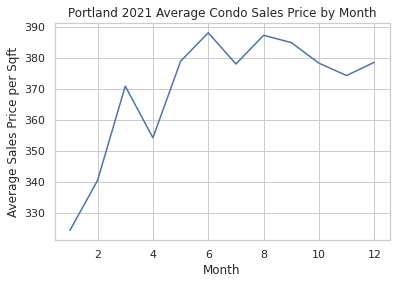

In [4]:
_ = (
    df
    .groupby(['SOLD_YEAR', 'SOLD_MONTH'])
    .agg(
        avg_price_per_sqft=('PRICE_PER_SQUARE_FEET', 'mean'),
        n_sales=('PRICE_PER_SQUARE_FEET', 'count'),
        )
    .reset_index()
    .query("SOLD_YEAR == 2021")
    .plot(kind='line', x='SOLD_MONTH', y='avg_price_per_sqft', legend=False)
    )

plt.title('Portland 2021 Average Condo Sales Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales Price per Sqft')
plt.show()

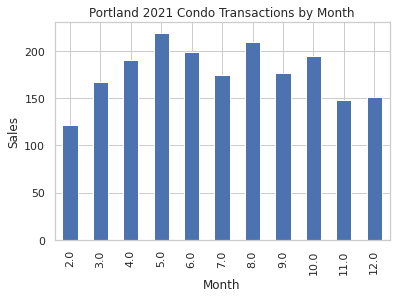

In [5]:
_ = (
    df
    .groupby(['SOLD_YEAR', 'SOLD_MONTH'])
    .agg(
        avg_price_per_sqft=('PRICE_PER_SQUARE_FEET', 'mean'),
        n_sales=('PRICE_PER_SQUARE_FEET', 'count'),
        )
    .reset_index()
    .query("SOLD_YEAR == 2021 & SOLD_MONTH > 1")
    .plot(kind='bar', x='SOLD_MONTH', y='n_sales', legend=False)
    )

plt.title('Portland 2021 Condo Transactions by Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

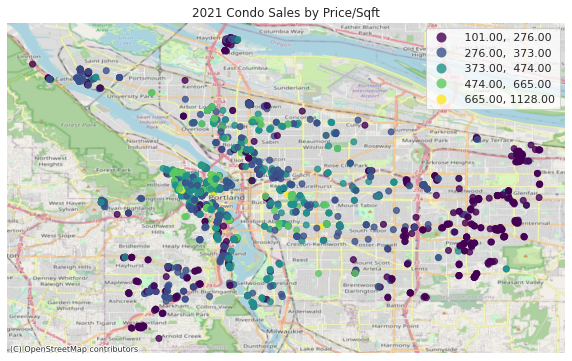

In [6]:
ax = df.plot(column='PRICE_PER_SQUARE_FEET', legend=True, scheme='fisherjenks', figsize=(10, 8), alpha=0.8)
ctx.add_basemap(ax=ax, crs=df.crs, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')
plt.title('2021 Condo Sales by Price/Sqft')
plt.show()

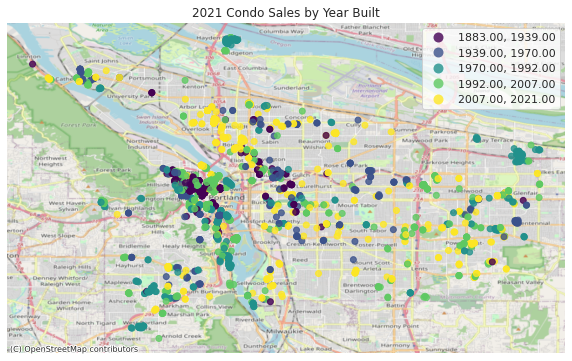

In [7]:
ax = df.plot(column='YEAR_BUILT', legend=True, scheme='fisherjenks', figsize=(10, 8), alpha=0.8)
ctx.add_basemap(ax=ax, crs=df.crs, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')
plt.title('2021 Condo Sales by Year Built')
plt.show()

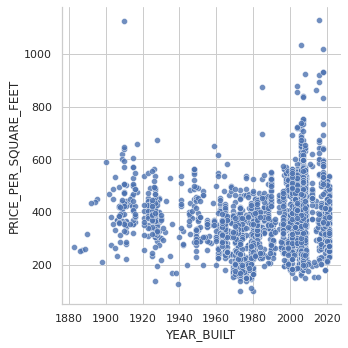

In [8]:
_ = sns.relplot(
    x='YEAR_BUILT',
    y='PRICE_PER_SQUARE_FEET',
    data=df,
    alpha=0.8
    )

In [9]:
df = pd.concat(
    [
        df, 
        df
        ['ADDRESS']
        .str.extract('(^\d{,5} )(NE|NW|SE|SW|N|E|S|W)(.+)', expand=True)
        .rename(columns={0:'address_number', 1:'address_direction', 2:'address_street'})
    ], axis=1
)

In [10]:
def estimate_unit_floor(df):
    if df['unit_len'] <= 2:
        return 1
    elif df['unit_len'] == 3:
        return int(df['unit_number'][0])
    elif df['unit_len'] == 4:
        return int(df['unit_number'][:1])

unit_floor_joiner = (
    df
    ['address_street']
    .str.lstrip()
    .str.split(' ', expand=True)
    .rename(columns={0:'tmp1', 1:'tmp2', 2:'unit_number'})
    .assign(street_name=lambda df_:df_['tmp1'] + ' ' + df_['tmp2'])
    .drop([3, 4, 5, 'tmp1', 'tmp2'], axis=1)
    .assign(
        unit_number=lambda df_: np.where(df_['unit_number'].str.replace('#', '').str.contains('\d'), df_['unit_number'].str.replace('#', ''), '0')
    )
    .assign(
        unit_number=lambda df_: df_['unit_number'].fillna('0'),
        unit_len=lambda df_: df_['unit_number'].str.len()
        )
    .assign(unit_floor=lambda df_: df_.apply(estimate_unit_floor, axis=1))
    .drop(['unit_number', 'unit_len'], axis=1)
    )

df = pd.concat([df, unit_floor_joiner], axis=1)

In [11]:
df = (
    df
    .assign(
        address_building=df['address_number'] + df['address_direction'] + ' ' + df['street_name']
        )
    .drop(['address_number', 'address_street', 'street_name'], axis=1)
    )

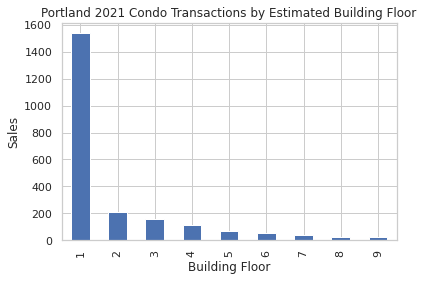

In [12]:
_ = (
    df
    .groupby(['unit_floor'])
    .agg(
        avg_price_per_sqft=('PRICE_PER_SQUARE_FEET', 'mean'),
        n_sales=('PRICE_PER_SQUARE_FEET', 'count'),
        )
    .reset_index()
    .plot(kind='bar', x='unit_floor', y='n_sales', legend=False)
    )

plt.title('Portland 2021 Condo Transactions by Estimated Building Floor')
plt.xlabel('Building Floor')
plt.ylabel('Sales')
plt.show()

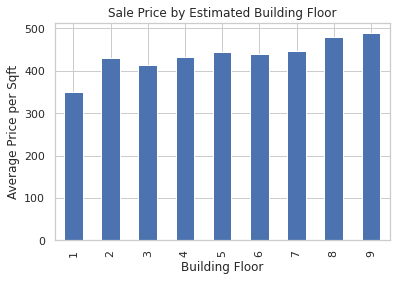

In [13]:
_ = (
    df
    .groupby(['unit_floor'])
    .agg(
        avg_price_per_sqft=('PRICE_PER_SQUARE_FEET', 'mean'),
        n_sales=('PRICE_PER_SQUARE_FEET', 'count'),
        )
    .reset_index()
    .plot(kind='bar', x='unit_floor', y='avg_price_per_sqft', legend=False)
    )

plt.title('Sale Price by Estimated Building Floor')
plt.xlabel('Building Floor')
plt.ylabel('Average Price per Sqft')
plt.show()

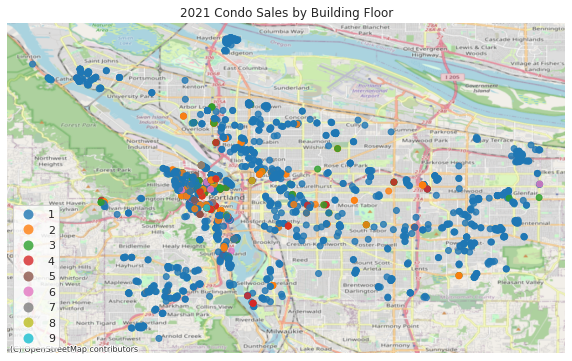

In [14]:
ax = df.plot(column='unit_floor', legend=True, categorical=True, figsize=(10, 8), alpha=0.8)
ctx.add_basemap(ax=ax, crs=df.crs, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')
plt.title('2021 Condo Sales by Building Floor')
plt.show()

In [19]:
(
    df
    .drop(['geometry'], axis=1)
    .to_sql(con=conn, name='tidyredfin_data', if_exists='replace')
)